# Re-Run Analyses with Polka et. al. Subset

In [1]:
from datetime import timedelta, date
from pathlib import Path
import sys

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import ConnectionPatch
from mizani.breaks import date_breaks
from mizani.formatters import timedelta_format
import numpy as np
import pandas as pd
import plotnine as p9
import requests
from scipy.spatial.distance import cdist
from scipy.stats import linregress
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import spacy
import tqdm

from annorxiver_modules.corpora_comparison_helper import (
    aggregate_word_counts,
    calculate_confidence_intervals,
    get_term_statistics,
)

sys.path.append(str(Path("../../../preprint_similarity_search/server").resolve()))
from SAUCIE import SAUCIE, Loader  # noqa: E402

mpl.rcParams["figure.dpi"] = 250

In [2]:
# Set up porting from python to R
# and R to python :mindblown:

import rpy2.rinterface  # noqa: E402

%load_ext rpy2.ipython

# Corpora Comparison Preprint-Published Update

## BioRxiv to Published Mapping

In [3]:
mapped_doi_df = (
    pd.read_csv("../journal_tracker/output/mapped_published_doi.tsv", sep="\t")
    .query("published_doi.notnull()")
    .query("pmcid.notnull()")
    .groupby("preprint_doi")
    .agg(
        {
            "author_type": "first",
            "heading": "first",
            "category": "first",
            "document": "first",
            "preprint_doi": "last",
            "published_doi": "last",
            "pmcid": "last",
        }
    )
    .reset_index(drop=True)
)
mapped_doi_df.head()

,author_type,heading,category,document,preprint_doi,published_doi,pmcid
0,regular article,new results,genetics,000026_v1.xml,10.1101/000026,10.1371/journal.pgen.1004412,PMC4125079
1,regular article,new results,genomics,000042_v1.xml,10.1101/000042,10.1038/nrg3723,PMC4151119
2,regular article,new results,genomics,000067_v1.xml,10.1101/000067,10.1038/nature12904,PMC4285441
3,regular article,new results,evolutionary biology,000109_v1.xml,10.1101/000109,10.1371/journal.pgen.1004410,PMC4072524
4,regular article,new results,cancer biology,000125_v1.xml,10.1101/000125,10.1016/j.ejca.2014.08.019,PMC4258103


In [4]:
polka_et_al_mapped_df = pd.read_csv(
    "output/polka_et_al_pmc_mapped_subset.tsv", sep="\t"
)
polka_et_al_mapped_df.head()

,biorxiv_doi,published_doi,PMID,PMCID,Version,MID,IsCurrent,IsLive,ReleaseDate,Msg
0,10.1101/2019.12.18.881391,10.1128/JVI.00426-20,32295925.0,PMC7307142,NaN,NaN,NaN,1,NaN,NaN
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,NaN,NaN,NaN,1,NaN,NaN
2,10.1101/2020.01.13.905190,10.1182/blood.2019002867,32128578.0,PMC7243144,NaN,NaN,NaN,1,NaN,NaN
3,10.1101/2020.01.21.914929,10.1128/AAC.00086-20,32284379.0,PMC7269492,NaN,NaN,NaN,1,NaN,NaN
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,NaN,NaN,NaN,1,NaN,NaN


In [5]:
spacy_nlp = spacy.load("en_core_web_sm")
stop_word_list = list(spacy_nlp.Defaults.stop_words)

## BioRxiv Token Counts

In [6]:
polka_preprints = list(Path("output/biorxiv_word_counts").rglob("*tsv"))

In [7]:
preprint_count = aggregate_word_counts(polka_preprints)

preprint_count_df = (
    pd.DataFrame.from_records(
        [
            {
                "lemma": token[0],
                "pos_tag": token[1],
                "dep_tag": token[2],
                "count": preprint_count[token],
            }
            for token in preprint_count
        ]
    )
    .query(f"lemma not in {stop_word_list}")
    .groupby("lemma")
    .agg({"count": "sum"})
    .reset_index()
    .sort_values("count", ascending=False)
)

preprint_count_df.head()

,lemma,count
14930,sars,1350
4304,cells,1167
6996,et,1162
2678,al,1160
4298,cell,878


## PMCOA Token Counts

In [8]:
polka_published = list(Path("output/pmcoa_word_counts").rglob("*tsv"))

In [9]:
published_count = aggregate_word_counts(polka_published)

published_count_df = (
    pd.DataFrame.from_records(
        [
            {
                "lemma": token[0],
                "pos_tag": token[1],
                "dep_tag": token[2],
                "count": published_count[token],
            }
            for token in published_count
        ]
    )
    .query(f"lemma not in {stop_word_list}")
    .groupby("lemma")
    .agg({"count": "sum"})
    .reset_index()
    .sort_values("count", ascending=False)
)

published_count_df.head()

,lemma,count
17489,,1506
14551,sars,1447
17647,,975
7294,et,833
3389,al,816


## Get Token Stats

In [10]:
preprint_vs_published = get_term_statistics(preprint_count_df, published_count_df, 100)
preprint_vs_published.to_csv(
    "output/updated_preprint_to_published_comparison.tsv", sep="\t", index=False
)
preprint_vs_published

,lemma,corpus_one_a,corpus_two_b,corpus_one_c,corpus_two_d,log_likelihood,odds_ratio
0,al,1161,817,182375,138320,2.685043,1.077779
1,stage,312,88,182375,138320,78.586469,2.689005
2,compared,261,149,182375,138320,7.821418,1.328538
3,rdna,219,229,182375,138320,11.507156,0.725318
4,actin,156,154,182375,138320,5.360748,0.768287
...,...,...,...,...,...,...,...
118,identified,203,130,182375,138320,2.291460,1.184329
119,1,667,521,182375,138320,0.252536,0.970974
120,control,202,85,182375,138320,22.213383,1.802404
121,region,198,153,182375,138320,0.030014,0.981507


In [11]:
full_plot_df = calculate_confidence_intervals(preprint_vs_published)
full_plot_df.head()

,lemma,corpus_one_a,corpus_two_b,corpus_one_c,corpus_two_d,log_likelihood,odds_ratio,lower_odds,upper_odds
0,al,1161,817,182375,138320,2.685043,1.077779,0.985236,1.179015
1,stage,312,88,182375,138320,78.586469,2.689005,2.122286,3.407056
2,compared,261,149,182375,138320,7.821418,1.328538,1.086225,1.624905
3,rdna,219,229,182375,138320,11.507156,0.725318,0.602585,0.873048
4,actin,156,154,182375,138320,5.360748,0.768287,0.614868,0.959986


In [12]:
plot_df = (
    full_plot_df.sort_values("odds_ratio", ascending=True)
    .iloc[3:]
    .head(20)
    .append(full_plot_df.sort_values("odds_ratio", ascending=False).head(20))
    .assign(
        odds_ratio=lambda x: x.odds_ratio.apply(lambda x: np.log2(x)),
        lower_odds=lambda x: x.lower_odds.apply(lambda x: np.log2(x)),
        upper_odds=lambda x: x.upper_odds.apply(lambda x: np.log2(x)),
    )
)
plot_df.head()

,lemma,corpus_one_a,corpus_two_b,corpus_one_c,corpus_two_d,log_likelihood,odds_ratio,lower_odds,upper_odds
78,s.,25,145,182375,138320,130.048103,-2.934951,-3.547386,-2.322516
34,±,100,395,182375,138320,278.635942,-2.380751,-2.697456,-2.064046
37,tert,71,147,182375,138320,52.191327,-1.448823,-1.857616,-1.040031
100,methylation,67,137,182375,138320,47.725392,-1.430841,-1.852511,-1.009172
51,information,103,151,182375,138320,27.214753,-0.950802,-1.312303,-0.589302


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 6 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/preprint_published_frequency_odds.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 6 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/preprint_published_frequency_odds.png


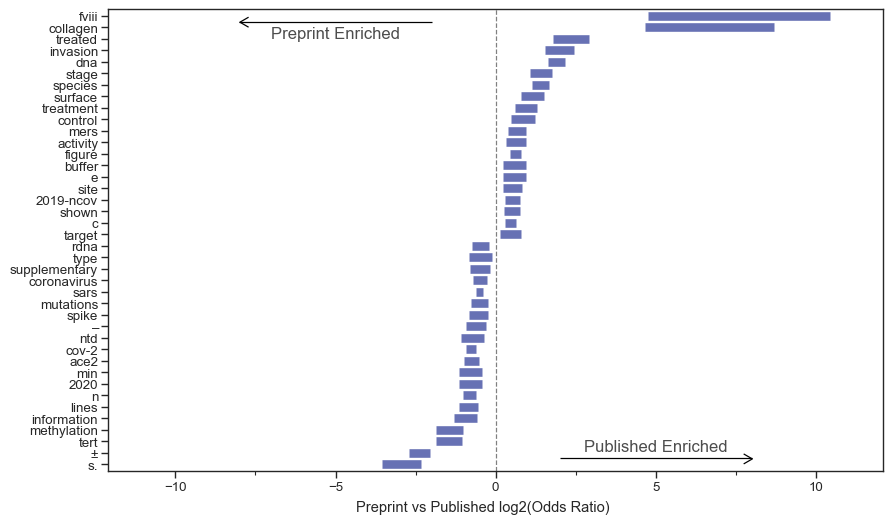

<ggplot: (-9223363278456994879)>


In [13]:
g = (
    p9.ggplot(
        plot_df, p9.aes(y="lemma", x="lower_odds", xend="upper_odds", yend="lemma")
    )
    + p9.geom_segment(color="#253494", size=3.5, alpha=0.7)
    + p9.scale_y_discrete(
        limits=(plot_df.sort_values("odds_ratio", ascending=True).lemma.tolist())
    )
    + p9.scale_x_continuous(limits=(-11, 11))
    + p9.geom_vline(p9.aes(xintercept=0), linetype="--", color="grey")
    + p9.annotate(
        "segment",
        x=2,
        xend=8,
        y=1.5,
        yend=1.5,
        colour="black",
        size=0.5,
        alpha=1,
        arrow=p9.arrow(length=0.1),
    )
    + p9.annotate("text", label="Published Enriched", x=5, y=2.5, size=12, alpha=0.7)
    + p9.annotate(
        "segment",
        x=-2,
        xend=-8,
        y=39.5,
        yend=39.5,
        colour="black",
        size=0.5,
        alpha=1,
        arrow=p9.arrow(length=0.1),
    )
    + p9.annotate("text", label="Preprint Enriched", x=-5, y=38.5, size=12, alpha=0.7)
    + p9.theme_seaborn(context="paper", style="ticks", font_scale=1.1, font="Arial")
    + p9.theme(
        figure_size=(10, 6),
        panel_grid_minor=p9.element_blank(),
    )
    + p9.labs(y=None, x="Preprint vs Published log2(Odds Ratio)")
)
g.save("output/figures/preprint_published_frequency_odds.svg")
g.save("output/figures/preprint_published_frequency_odds.png", dpi=250)
print(g)

# Document Embeddings

## Load the Documents

In [14]:
biorxiv_documents_df = pd.read_csv(
    "../word_vector_experiment/output/word2vec_output/biorxiv_all_articles_300.tsv.xz",
    sep="\t",
)
biorxiv_documents_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,-0.185549,-0.028703,-0.148555,-0.133172,0.353365,-0.114964,-0.028663,-0.215159,0.551382,...,-0.286513,0.082141,-0.197929,-0.163326,-0.867377,-0.383934,0.684275,0.673811,0.332528,-0.252338
1,775270_v1.xml,-0.532040,-0.065809,-0.313654,-0.117575,0.372866,-0.318956,-0.368010,0.325850,0.808698,...,-0.199805,-0.083095,0.184185,-0.157145,-0.895367,-0.611417,0.224433,0.857584,-0.442240,-0.229249
2,242404_v1.xml,-0.511104,-0.203790,-0.171574,0.244052,0.235567,-0.269997,-0.222966,-0.247174,0.385497,...,-0.351890,-0.155088,-0.222041,-0.258185,-0.866121,-0.568663,0.553375,0.890001,0.025051,-0.347382
3,872994_v1.xml,-0.595936,-0.147790,-0.277296,0.522433,0.574653,-0.046103,-0.586993,-0.312505,0.382142,...,0.074240,0.042758,0.174565,0.155595,-0.557984,-0.445246,0.386596,0.512007,-0.510197,-0.295844
4,080853_v2.xml,-0.076522,0.039275,-0.928818,0.226103,0.035823,-0.075580,-0.189354,0.243075,0.240977,...,0.524121,0.560223,0.246179,0.242929,-0.810809,-0.118951,0.052647,0.184235,-0.154029,0.469902


In [15]:
polka_preprints_df = pd.read_csv("output/polka_et_al_biorxiv_embeddings.tsv", sep="\t")
polka_preprints_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,838870_v1.xml,-0.480256,-0.171600,-0.038858,-0.021049,-0.123947,0.000535,0.093438,0.047984,0.145099,...,0.085048,-0.031033,0.066536,-0.167005,-0.739374,-0.294772,0.209652,0.638616,-0.021095,0.307290
1,2020.02.13.945485_v1.xml,-0.526527,0.013894,-0.059100,0.041509,-0.201001,-0.087865,0.119310,0.161984,0.183911,...,-0.130013,0.296040,-0.158121,0.069174,-0.816756,-0.070580,0.509606,0.487253,-0.032900,0.356710
2,2020.01.13.905190_v1.xml,0.049744,0.058256,-0.828798,-0.477814,0.418510,-0.229253,-0.038192,0.181501,0.378143,...,0.281319,0.272860,0.067832,-0.112391,-0.206888,0.177389,0.374656,0.136399,-0.516485,0.555315
3,865089_v1.xml,0.133945,0.149573,-0.497015,0.186168,-0.000991,-0.139000,0.169656,0.316791,0.482602,...,0.283557,0.596697,0.066394,-0.244679,-0.664269,0.126316,0.233592,-0.127426,-0.238472,0.333090
4,832675_v1.xml,0.120574,0.435998,-0.730727,-0.144449,0.446718,-0.239434,-0.230699,0.217322,0.742177,...,0.365835,0.279918,0.306694,-0.300575,-0.481866,-0.809388,0.447944,0.241587,-0.461618,-0.102931


In [16]:
pca_components = pd.read_csv(
    Path("../pca_association_experiment/output/word_pca_similarity/pca_components.tsv"),
    sep="\t",
)
pca_components.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,-0.063058,-0.031987,0.056669,0.060172,0.051338,0.000702,-0.036021,-0.048121,0.012963,0.081663,...,-0.075332,-0.049486,-0.006447,0.034889,-0.030875,-0.022924,0.044628,0.079822,-0.006788,-0.097747
1,-0.027159,0.026662,0.029738,-0.114572,-0.073464,0.010639,0.066597,0.047968,-0.029194,-0.106212,...,-0.004370,0.024299,-0.044685,0.029420,-0.022982,0.004105,0.018769,0.056500,0.104248,0.086035
2,0.051539,0.096684,0.075631,-0.080821,-0.018708,0.026179,0.098675,-0.045142,0.025622,0.096555,...,-0.026226,0.090037,-0.065594,-0.039290,-0.122291,-0.048111,0.043212,0.003178,0.078463,-0.078340
3,0.028913,0.045534,-0.041061,-0.057960,0.075108,0.019520,-0.061518,-0.062363,0.016611,-0.066524,...,-0.024171,0.078107,-0.031124,0.124928,-0.001915,0.134990,0.132208,-0.069076,0.085626,0.015349
4,-0.108193,-0.015217,-0.025340,-0.057654,0.097232,0.020200,-0.069443,-0.048466,-0.016571,-0.014490,...,0.038276,0.010970,0.058624,0.088282,-0.031494,-0.047169,-0.004626,0.120189,0.075799,-0.003777


## PCA Components

In [17]:
document_pca_sim = 1 - cdist(
    polka_preprints_df.drop("document", axis=1).values, pca_components.values, "cosine"
)
print(document_pca_sim.shape)
document_pca_sim

(60, 50)


array([[ 0.49695047,  0.4730278 , -0.03245816, ...,  0.07337215,
         0.03135603, -0.03371951],
       [ 0.40068716,  0.55388902, -0.03312836, ...,  0.05327869,
         0.06194184, -0.04585316],
       [-0.45182403,  0.02277632, -0.09395371, ...,  0.08515216,
         0.02854872, -0.08201045],
       ...,
       [-0.04017025, -0.02031854,  0.05253302, ...,  0.06197895,
         0.02791499, -0.09850894],
       [ 0.50230436,  0.16479526,  0.21807805, ...,  0.07640696,
         0.03571536, -0.01726621],
       [-0.30527726,  0.13529314, -0.3966169 , ...,  0.07789673,
         0.05096604, -0.04453899]])

In [18]:
document_to_pca_map = {
    document: document_pca_sim[idx, :]
    for idx, document in enumerate(polka_preprints_df.document.tolist())
}

In [19]:
polka_pca_sim_df = (
    pd.DataFrame.from_dict(document_to_pca_map, orient="index")
    .rename(index=str, columns={col: f"pc{col+1}" for col in range(int(300))})
    .reset_index()
    .rename(index=str, columns={"index": "document"})
)
polka_pca_sim_df.to_csv("output/polka_pca_enrichment.tsv", sep="\t")
polka_pca_sim_df = polka_pca_sim_df.assign(label="polka")
polka_pca_sim_df.head()

,document,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,label
0,838870_v1.xml,0.496950,0.473028,-0.032458,-0.104016,0.036788,-0.149372,0.063260,0.124719,0.125005,...,0.038093,-0.127657,-0.126796,0.002376,0.127495,0.026185,0.073372,0.031356,-0.033720,polka
1,2020.02.13.945485_v1.xml,0.400687,0.553889,-0.033128,-0.001304,0.035543,-0.076456,-0.000604,0.094278,0.119023,...,-0.052530,-0.073155,-0.043533,0.046980,0.100240,-0.011275,0.053279,0.061942,-0.045853,polka
2,2020.01.13.905190_v1.xml,-0.451824,0.022776,-0.093954,0.244992,0.173088,-0.172388,0.328871,-0.113022,0.031420,...,0.022715,-0.100833,-0.048190,0.051187,0.133296,-0.019289,0.085152,0.028549,-0.082010,polka
3,865089_v1.xml,-0.142371,-0.250305,0.194930,0.092776,-0.102038,-0.124859,0.204122,0.224142,-0.026322,...,0.078104,-0.172374,-0.118485,-0.014561,0.173481,-0.007756,0.078603,0.041159,-0.072553,polka
4,832675_v1.xml,-0.190222,0.002005,0.045601,0.098558,0.205548,-0.307783,0.371094,-0.083000,0.068016,...,-0.012284,-0.150930,-0.053932,0.014384,0.097312,0.014864,0.025926,0.060891,0.019093,polka


In [20]:
document_pca_sim = 1 - cdist(
    biorxiv_documents_df.drop("document", axis=1).values,
    pca_components.values,
    "cosine",
)
print(document_pca_sim.shape)
document_pca_sim

(97952, 50)


array([[ 6.10555442e-01,  2.79363349e-01,  2.94518857e-01, ...,
         5.94232468e-02,  4.41999260e-02, -6.38560938e-02],
       [ 6.20834117e-01,  8.10645320e-02,  1.22438110e-01, ...,
        -5.28286939e-04,  4.92336288e-02, -5.13378458e-02],
       [ 7.03044697e-01,  2.77773792e-01,  1.09066018e-01, ...,
         2.47145256e-02,  3.62413769e-02, -5.89982097e-02],
       ...,
       [ 5.47225412e-01,  3.56613369e-01,  2.19258874e-01, ...,
         2.20569339e-02,  4.03272476e-02, -6.81529439e-02],
       [ 4.76586252e-01,  1.40518333e-01, -2.63646095e-01, ...,
         4.96015037e-02,  6.09843508e-02, -3.34716129e-02],
       [ 4.36261190e-01,  4.39156289e-02,  3.69007793e-01, ...,
         4.06675941e-02,  9.07339988e-02, -1.35638261e-02]])

In [21]:
document_to_pca_map = {
    document: document_pca_sim[idx, :]
    for idx, document in enumerate(biorxiv_documents_df.document.tolist())
}

In [22]:
biorxiv_pca_sim_df = (
    pd.DataFrame.from_dict(document_to_pca_map, orient="index")
    .rename(index=str, columns={col: f"pc{col+1}" for col in range(int(300))})
    .reset_index()
    .rename(index=str, columns={"index": "document"})
    .assign(label="biorxiv")
)
# biorxiv_pca_sim_df.to_csv("output/polka_pca_enrichment.tsv", sep="\t")
biorxiv_pca_sim_df.head()

,document,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,label
0,440735_v1.xml,0.610555,0.279363,0.294519,0.173476,-0.037744,-0.216465,0.237542,-0.060150,-0.035091,...,0.018228,-0.085539,-0.074343,-0.019240,0.111454,-0.011711,0.059423,0.044200,-0.063856,biorxiv
1,775270_v1.xml,0.620834,0.081065,0.122438,0.001843,0.164192,0.025213,0.400093,-0.002521,0.201918,...,-0.021736,-0.076156,-0.064014,-0.011912,0.114265,-0.028132,-0.000528,0.049234,-0.051338,biorxiv
2,242404_v1.xml,0.703045,0.277774,0.109066,0.066948,-0.083561,-0.292268,0.246609,0.005327,0.010737,...,0.011164,-0.072378,-0.059856,0.012369,0.131253,0.019025,0.024715,0.036241,-0.058998,biorxiv
3,872994_v1.xml,0.675625,-0.145204,-0.208231,0.190119,0.027041,-0.294223,0.166720,0.064516,0.007765,...,0.033558,-0.095098,-0.079106,-0.009931,0.104774,-0.006202,-0.015733,0.067611,-0.053497,biorxiv
4,080853_v2.xml,-0.077342,-0.084322,0.074639,0.318962,0.229314,-0.199079,0.252470,0.418123,0.124057,...,-0.036730,-0.100236,-0.122934,0.044116,0.111599,0.021361,0.078730,0.038969,-0.037518,biorxiv


## PC Regression

### Logistic Regression

Goal here is to determine if we can figure out which PCs bisect the bioRxiv subset against Polka et al.'s subset. Given that their dataset is only 60 papers we downsampled our dataset to contain only 60 papers.

In [23]:
dataset_df = biorxiv_pca_sim_df.sample(60, random_state=100).append(polka_pca_sim_df)
dataset_df.head()

,document,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,label
6042,713933_v1.xml,0.112781,0.100133,-0.386806,0.224485,0.380893,-0.094880,0.079920,-0.079893,-0.090176,...,-0.005665,-0.036556,-0.125692,0.025859,0.117151,-0.047832,0.098194,0.076594,-0.065666,biorxiv
26252,476978_v4.xml,-0.320633,0.037835,-0.018931,0.326432,0.211269,-0.295262,0.296738,-0.151838,0.100812,...,-0.036888,-0.137783,-0.098475,-0.006387,0.144682,-0.000050,0.004960,0.009747,-0.089720,biorxiv
72689,590794_v1.xml,0.334803,-0.002163,-0.030770,0.401054,0.377840,-0.116289,0.324855,0.259873,0.041167,...,0.004639,-0.074153,-0.080584,0.006003,0.110173,0.007617,0.032106,0.058310,-0.045245,biorxiv
21167,153759_v1.xml,0.695000,-0.156366,-0.204973,0.313477,-0.006925,-0.023350,0.224216,0.099561,0.091120,...,0.030855,-0.068859,-0.113331,0.013629,0.086002,0.027389,0.006013,0.051752,-0.065481,biorxiv
41933,174920_v1.xml,0.352177,0.467051,0.047054,-0.130410,0.170375,-0.267540,0.003610,0.099411,0.157444,...,-0.003075,-0.109553,-0.094928,-0.016066,0.152641,-0.005375,0.025203,0.032676,-0.041992,biorxiv


In [24]:
model = LogisticRegressionCV(
    cv=10, Cs=100, max_iter=1000, penalty="l1", solver="liblinear"
)
model.fit(
    StandardScaler().fit_transform(dataset_df[[f"pc{idx+1}" for idx in range(50)]]),
    dataset_df["label"],
)

LogisticRegressionCV(Cs=100, cv=10, max_iter=1000, penalty='l1',
                     solver='liblinear')

In [25]:
best_result = list(filter(lambda x: x[1] == model.C_, enumerate(model.Cs_)))[0]
print(best_result)

(90, 1873.8174228603868)


In [26]:
print("Best CV Fold")
print(model.scores_["polka"][:, best_result[0]])
model.scores_["polka"][:, best_result[0]].mean()

Best CV Fold
[0.75       0.83333333 0.91666667 1.         0.75       1.
 0.75       0.83333333 0.83333333 0.75      ]


0.8416666666666668

In [27]:
model_weights_df = pd.DataFrame.from_dict(
    {
        "weight": model.coef_[0],
        "pc": list(range(1, 51)),
    }
)
model_weights_df["pc"] = pd.Categorical(model_weights_df["pc"])
model_weights_df.head()

,weight,pc
0,-3.802937,1
1,2.662333,2
2,2.873036,3
3,-1.362650,4
4,-0.294143,5


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/pca_log_regression_weights.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/pca_log_regression_weights.png


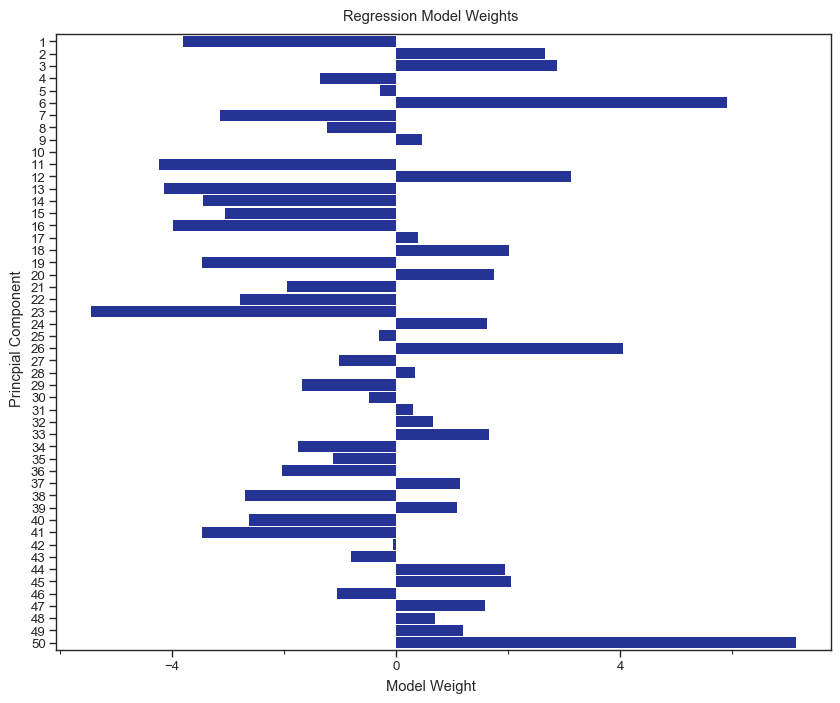

<ggplot: (8758387828947)>


In [28]:
g = (
    p9.ggplot(model_weights_df, p9.aes(x="pc", y="weight"))
    + p9.geom_col(position=p9.position_dodge(width=5), fill="#253494")
    + p9.coord_flip()
    + p9.scale_x_discrete(limits=list(sorted(range(1, 51), reverse=True)))
    + p9.theme_seaborn(context="paper", style="ticks", font_scale=1.1, font="Arial")
    + p9.theme(figure_size=(10, 8))
    + p9.labs(
        title="Regression Model Weights", x="Princpial Component", y="Model Weight"
    )
)
g.save("output/figures/pca_log_regression_weights.svg")
g.save("output/figures/pca_log_regression_weights.png", dpi=250)
print(g)

### Decision Tree

In [29]:
model = DecisionTreeClassifier(random_state=100)
search_grid = GridSearchCV(
    model, {"criterion": ["gini", "entropy"], "max_features": ["auto", None]}, cv=10
)
search_grid.fit(dataset_df[[f"pc{idx+1}" for idx in range(50)]], dataset_df["label"])

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', None]})

In [30]:
print(search_grid.best_params_)
print(search_grid.best_score_)

{'criterion': 'entropy', 'max_features': None}
0.7249999999999999


In [31]:
export_graphviz(
    search_grid.best_estimator_,
    out_file="output/figures/pca_tree.dot",
    feature_names=[f"pc{idx+1}" for idx in range(50)],
    class_names=["bioRxiv", "polka et al."],
    rotate=True,
)

In [32]:
! dot -Tpng output/figures/pca_tree.dot -o output/figures/pca_tree.png

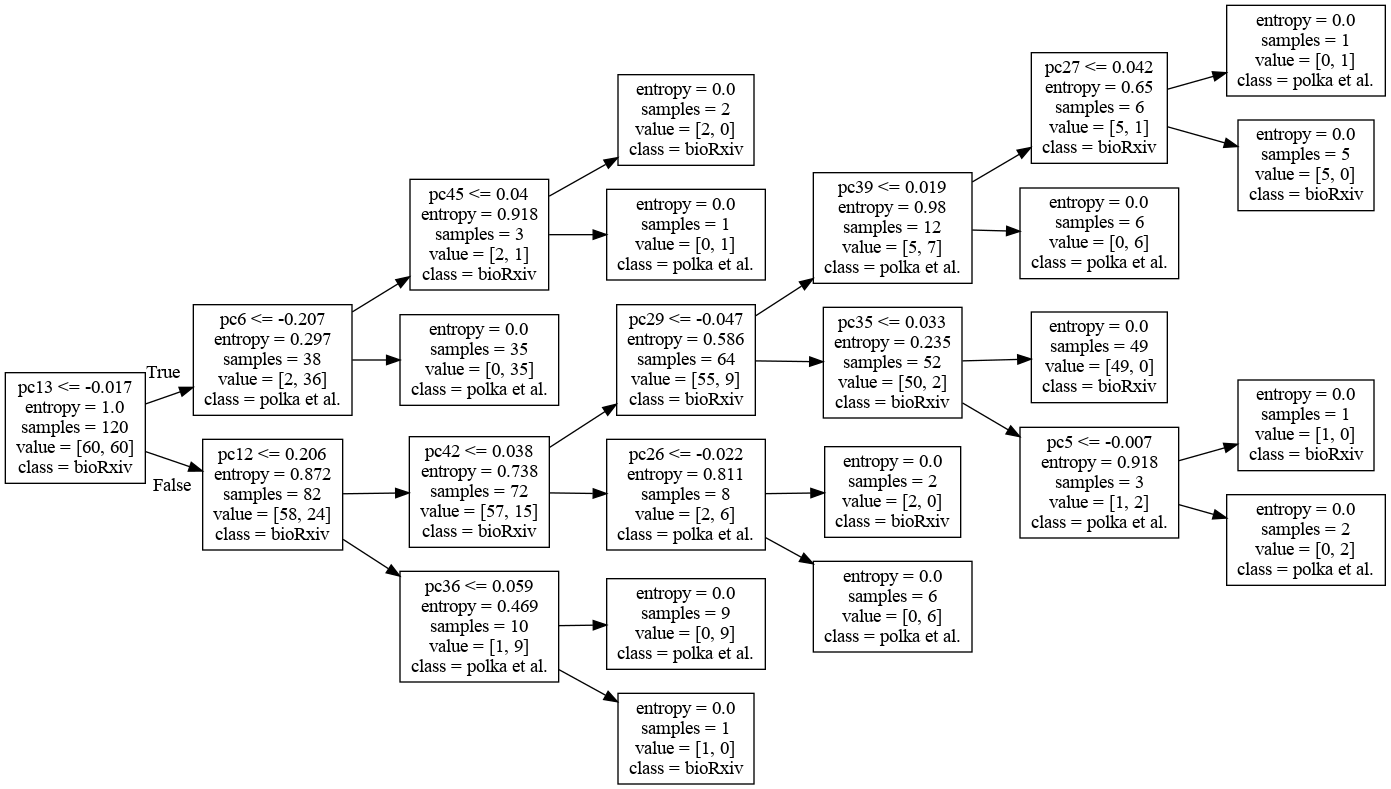

In [33]:
Image(filename="output/figures/pca_tree.png")

## Saucie Subset

In [34]:
saucie_model = SAUCIE(
    300,
    restore_folder=str(Path("../../pmc/journal_recommendation/output/model").resolve()),
)

INFO:tensorflow:Restoring parameters from /home/danich1/Documents/annorxiver/pmc/journal_recommendation/output/model/SAUCIE
Model restored from /home/danich1/Documents/annorxiver/pmc/journal_recommendation/output/model


In [35]:
coordinates = saucie_model.get_embedding(
    Loader(polka_preprints_df.drop("document", axis=1).values)
)

In [36]:
subset_df = pd.DataFrame(coordinates, columns=["dim1", "dim2"])
subset_df.head()

,dim1,dim2
0,-4.078402,-4.449113
1,-4.306172,-4.089919
2,0.411896,0.027609
3,0.916359,-0.994889
4,1.326494,1.356741


In [37]:
pmc_data_df = pd.read_csv(
    Path("../../pmc/journal_recommendation/output")
    / Path("paper_dataset/paper_dataset_full_tsne.tsv"),
    sep="\t",
)
pmc_data_df.head()

,dim1,dim2,journal,document
0,6.171382,-2.734631,Environ_Health,PMC1552054
1,3.787912,2.956243,Environ_Health,PMC1226148
2,6.044377,-5.623827,Environ_Health,PMC5635510
3,9.605969,-3.003096,Environ_Health,PMC3125232
4,6.118244,-4.301338,Environ_Health,PMC3533997


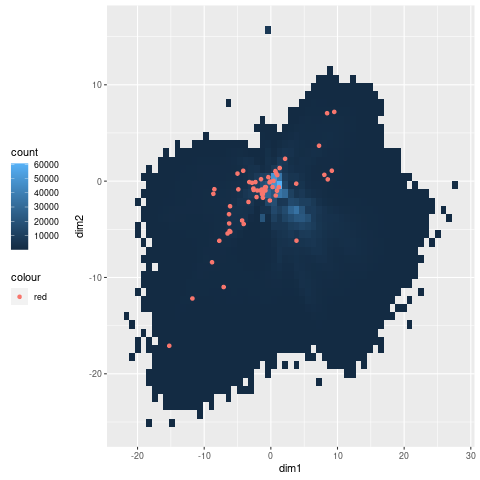

In [38]:
%%R -i pmc_data_df -i subset_df

library(ggplot2)

bin_num <- 50
g <- (
     ggplot(pmc_data_df, aes(x=dim1, y=dim2))

In [ ]:
# )
# print(g)

## Publication Time Analysis

### Get publication dates

In [39]:
url = "https://api.biorxiv.org/pub/2019-11-01/3000-01-01/"

In [40]:
# Get preprint publication dates for 2019 -> 2020
already_downloaded = Path("output/biorxiv_published_dates_post_2019.tsv").exists()
if not already_downloaded:
    collection = []
    page_size = 100
    total = 23948
    for i in tqdm.tqdm(range(0, total, page_size), total=total / page_size):
        collection += requests.get(url + str(i)).json()["collection"]
    published_dates = pd.DataFrame(collection)
    published_dates.to_csv(
        "output/biorxiv_published_dates_post_2019.tsv", sep="\t", index=False
    )
else:
    published_dates = pd.read_csv(
        "output/biorxiv_published_dates_post_2019.tsv", sep="\t"
    )

published_dates = published_dates.assign(
    preprint_date=lambda x: pd.to_datetime(x.preprint_date.tolist()),
    published_date=lambda x: pd.to_datetime(
        x.published_date.apply(lambda y: y[0 : y.index(":")] if ":" in y else y)
    ),
).assign(time_to_published=lambda x: x.published_date - x.preprint_date)
print(published_dates.shape)
published_dates.head()

(24000, 8)


,biorxiv_doi,published_doi,preprint_title,preprint_category,preprint_date,published_date,published_citation_count,time_to_published
0,10.1101/439315,10.1364/boe.10.000029,"Fast, volumetric live-cell imaging using high-...",bioengineering,2018-10-10,2019-12-04,3,420 days
1,10.1101/256750,10.1093/bioinformatics/bty980,Computational modelling of atherosclerosis: de...,physiology,2018-01-30,2019-12-06,0,675 days
2,10.1101/323154,10.1038/s41467-019-09230-w,Accurate autocorrelation modeling substantiall...,neuroscience,2018-05-16,2019-12-25,0,588 days
3,10.1101/149013,10.1126/sciadv.aat5077,Variable sensitivity to DNA damaging chemother...,systems biology,2017-06-12,2019-12-19,0,920 days
4,10.1101/350538,10.1038/s41591-020-1040-z,Single cell RNAseq provides a molecular and ce...,genomics,2018-06-19,2020-09-14,0,818 days


In [41]:
polka_preprints_df = polka_preprints_df.assign(
    biorxiv_base=lambda x: x.document.apply(lambda y: y.split("_")[0]),
    version_count=lambda x: x.document.apply(
        lambda y: int(y[y.index("v") + 1 :].split(".")[0])
    ),
)
polka_preprints_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299,biorxiv_base,version_count
0,838870_v1.xml,-0.480256,-0.171600,-0.038858,-0.021049,-0.123947,0.000535,0.093438,0.047984,0.145099,...,0.066536,-0.167005,-0.739374,-0.294772,0.209652,0.638616,-0.021095,0.307290,838870,1
1,2020.02.13.945485_v1.xml,-0.526527,0.013894,-0.059100,0.041509,-0.201001,-0.087865,0.119310,0.161984,0.183911,...,-0.158121,0.069174,-0.816756,-0.070580,0.509606,0.487253,-0.032900,0.356710,2020.02.13.945485,1
2,2020.01.13.905190_v1.xml,0.049744,0.058256,-0.828798,-0.477814,0.418510,-0.229253,-0.038192,0.181501,0.378143,...,0.067832,-0.112391,-0.206888,0.177389,0.374656,0.136399,-0.516485,0.555315,2020.01.13.905190,1
3,865089_v1.xml,0.133945,0.149573,-0.497015,0.186168,-0.000991,-0.139000,0.169656,0.316791,0.482602,...,0.066394,-0.244679,-0.664269,0.126316,0.233592,-0.127426,-0.238472,0.333090,865089,1
4,832675_v1.xml,0.120574,0.435998,-0.730727,-0.144449,0.446718,-0.239434,-0.230699,0.217322,0.742177,...,0.306694,-0.300575,-0.481866,-0.809388,0.447944,0.241587,-0.461618,-0.102931,832675,1


In [42]:
polka_published_df = pd.read_csv("output/polka_et_al_pmcoa_embeddings.tsv", sep="\t")
polka_published_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,PMC7095418,-0.196777,-0.092369,-0.342167,-0.115627,-0.307616,-0.177895,0.103362,0.429124,0.393074,...,0.105730,0.133122,-0.211047,-0.191748,-0.665143,-0.166095,0.368638,0.203294,-0.425629,0.540340
1,PMC7054013,-0.242958,0.176935,-0.379532,-0.187553,0.092709,-0.125776,0.081895,0.105365,-0.085186,...,0.511963,0.343716,0.210594,-0.094254,-0.400238,-0.103187,0.551733,0.478303,0.048200,0.104997
2,PMC7182430,-0.420515,-0.296674,-0.526647,0.042494,0.336494,-0.126947,-0.289248,0.157978,0.489823,...,0.267131,0.061372,0.333005,-0.023712,-0.355014,-0.243082,0.603597,0.453615,-0.308290,0.102998
3,PMC7176908,-0.179555,-0.055011,-0.240822,0.320286,0.008491,-0.131329,0.152214,0.218921,0.179175,...,0.559408,0.084215,-0.110226,0.092122,-0.570880,-0.486879,-0.065053,0.538904,0.191572,0.299047
4,PMC6907167,-0.089865,0.055203,-0.515187,0.647070,0.110433,0.318210,0.021561,0.029749,0.169143,...,0.329317,0.386622,0.378009,0.574915,-0.698231,0.169077,0.277399,0.128918,-0.071585,0.353283


In [43]:
polka_published_preprint_df = (
    polka_et_al_mapped_df.drop(
        ["Version", "MID", "IsCurrent", "IsLive", "ReleaseDate", "Msg"], axis=1
    )
    .assign(biorxiv_base=lambda x: x.biorxiv_doi.apply(lambda y: y.split("/")[1]))
    .merge(
        polka_preprints_df.drop([f"feat_{idx}" for idx in range(300)], axis=1),
        on="biorxiv_base",
    )
    .drop("document", axis=1)
    .merge(
        published_dates.drop(["published_citation_count", "preprint_title"], axis=1),
        on=["biorxiv_doi", "published_doi"],
    )
    .query(f"PMCID in {polka_published_df['document'].tolist()}")
)
polka_published_preprint_df.head()

,biorxiv_doi,published_doi,PMID,PMCID,biorxiv_base,version_count,preprint_category,preprint_date,published_date,time_to_published
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,2019.12.19.882274,1,plant biology,2019-12-19,2020-04-16,119 days
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,2020.01.22.914952,2,microbiology,2020-01-23,2020-02-03,11 days
5,10.1101/2020.01.22.915660,10.1038/s41564-020-0688-y,32094589.0,PMC7095430,2020.01.22.915660,1,microbiology,2020-01-22,2020-02-24,33 days
6,10.1101/2020.01.23.916395,10.1016/j.ijid.2020.01.050,32007643.0,PMC7110798,2020.01.23.916395,2,ecology,2020-01-24,2020-01-30,6 days
7,10.1101/2020.01.24.915157,10.1002/jmv.25688,31994738.0,PMC7166400,2020.01.24.915157,1,bioinformatics,2020-01-24,2020-01-29,5 days


In [44]:
for col in ["preprint_date", "published_date"]:
    polka_published_preprint_df[col] = pd.to_datetime(polka_published_preprint_df[col])

polka_published_preprint_df["time_to_published"] = pd.to_timedelta(
    polka_published_preprint_df["time_to_published"]
)
polka_published_preprint_df["days_to_published"] = polka_published_preprint_df[
    "time_to_published"
].dt.days
print(polka_published_preprint_df.shape)
polka_published_preprint_df.head()

(39, 11)


,biorxiv_doi,published_doi,PMID,PMCID,biorxiv_base,version_count,preprint_category,preprint_date,published_date,time_to_published,days_to_published
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,2019.12.19.882274,1,plant biology,2019-12-19,2020-04-16,119 days,119
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,2020.01.22.914952,2,microbiology,2020-01-23,2020-02-03,11 days,11
5,10.1101/2020.01.22.915660,10.1038/s41564-020-0688-y,32094589.0,PMC7095430,2020.01.22.915660,1,microbiology,2020-01-22,2020-02-24,33 days,33
6,10.1101/2020.01.23.916395,10.1016/j.ijid.2020.01.050,32007643.0,PMC7110798,2020.01.23.916395,2,ecology,2020-01-24,2020-01-30,6 days,6
7,10.1101/2020.01.24.915157,10.1002/jmv.25688,31994738.0,PMC7166400,2020.01.24.915157,1,bioinformatics,2020-01-24,2020-01-29,5 days,5


### Document version count plot

In [45]:
biorxiv_published_distances = pd.read_csv(
    "../publication_delay_experiment/output/preprint_published_distances.tsv", sep="\t"
)
biorxiv_published_distances["time_to_published"] = pd.to_timedelta(
    biorxiv_published_distances["time_to_published"]
)
biorxiv_published_distances["days_to_published"] = biorxiv_published_distances[
    "time_to_published"
].dt.days
biorxiv_published_distances.head()

,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,journal,preprint_date,published_date,time_to_published,doc_distances,days_to_published
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,PLoS_Genet,2013-11-07,2014-08-07,273 days,1.640911,273
1,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,Nature,2013-11-07,2014-02-27,112 days,1.683717,112
2,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,PLoS_Genet,2013-11-07,2014-06-26,231 days,1.244658,231
3,10.1101/000141,000141_v1.xml,cancer biology,1,10.1371/journal.pcbi.1003433,PMC3894166,True,PLoS_Comput_Biol,2013-11-07,2014-01-16,70 days,0.972641,70
4,10.1101/000158,000158_v1.xml,bioinformatics,1,10.1186/1471-2164-15-398,PMC4041996,True,BMC_Genomics,2013-11-11,2014-05-24,194 days,1.077589,194


In [46]:
# Get smoothed linear regression line
x = biorxiv_published_distances.version_count.values.tolist()

y = biorxiv_published_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=50.64348658359682, intercept=133.2764813966088, rvalue=0.30323124233888693, pvalue=0.0, stderr=1.2021972071824731, intercept_stderr=2.037774663358869)


In [47]:
x_line = np.array(
    [
        biorxiv_published_distances["version_count"].min(),
        biorxiv_published_distances["version_count"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

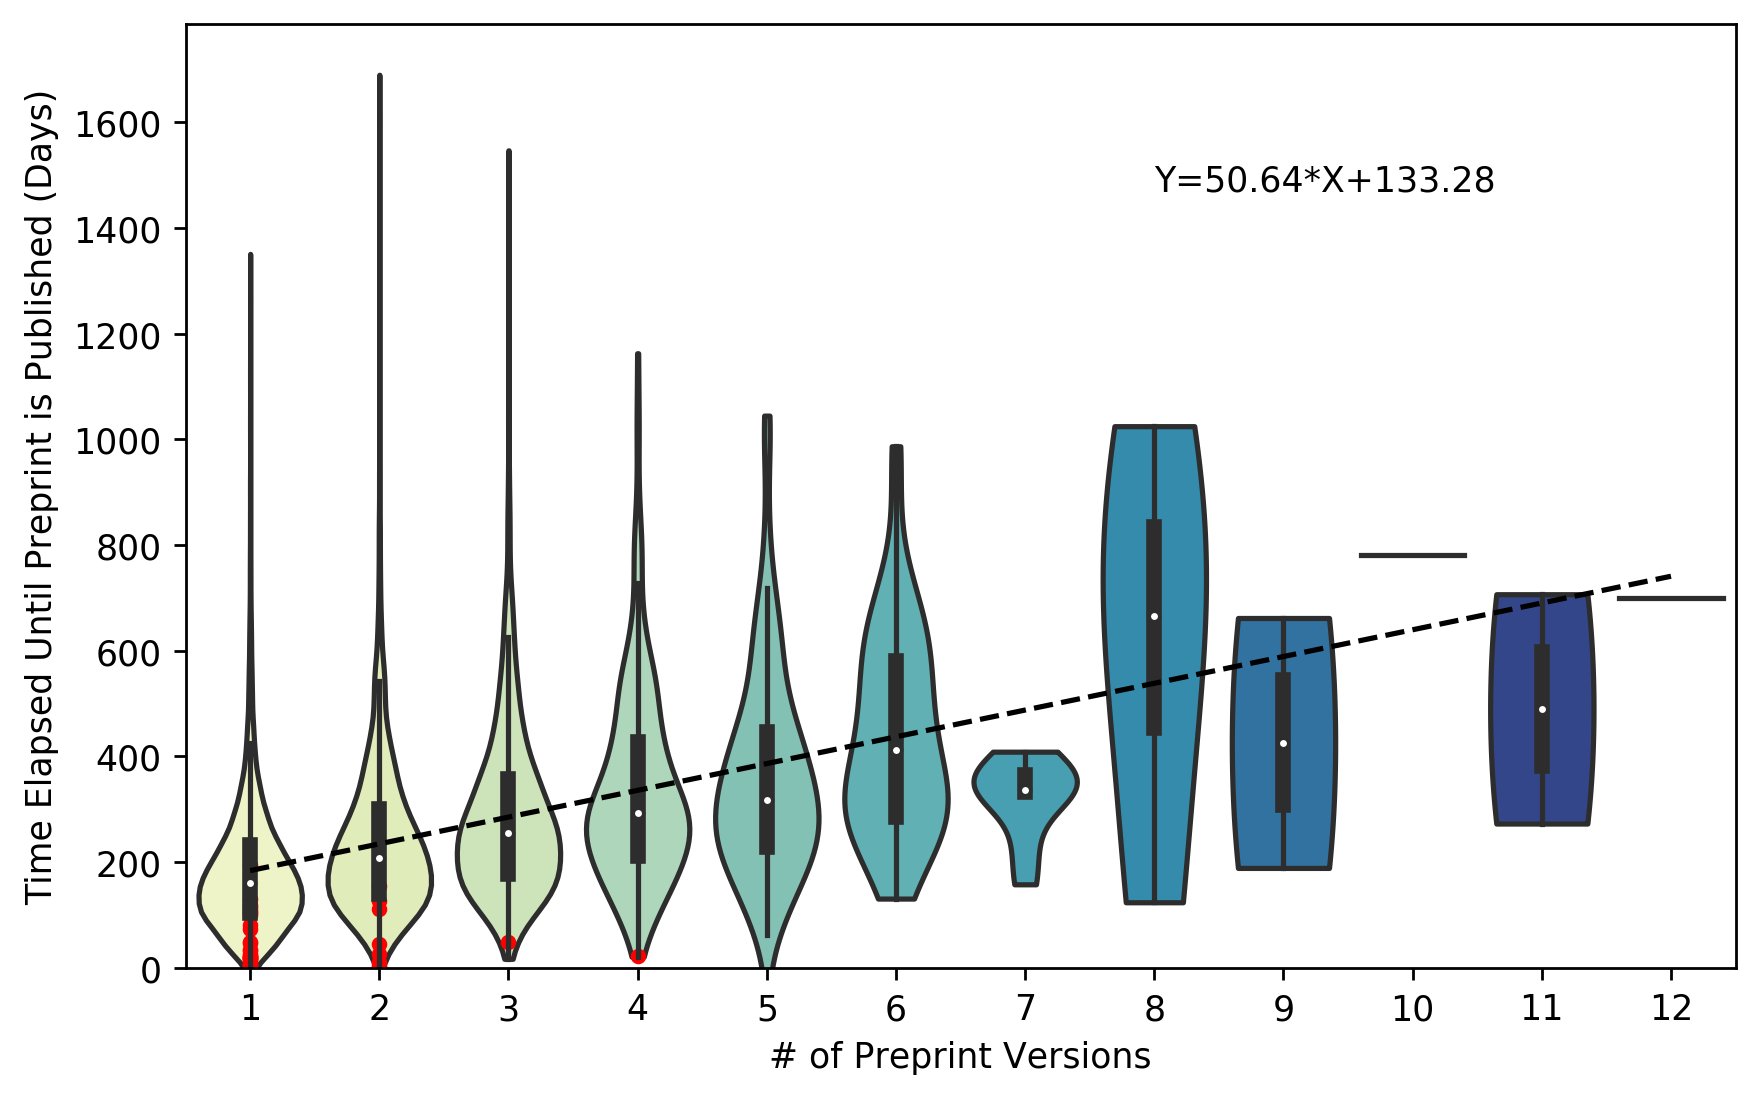

In [48]:
# Graph here?
plt.figure(figsize=(8, 5))
g = sns.violinplot(
    x="version_count",
    y="days_to_published",
    data=biorxiv_published_distances,
    cut=0,
    scale="width",
    palette="YlGnBu",
)
_ = g.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
_ = g.set_xlabel("# of Preprint Versions")
_ = g.plot(x_line - 1, y_line, "--k")
_ = g.scatter(
    polka_published_preprint_df["version_count"] - 1,
    polka_published_preprint_df["days_to_published"],
    c="red",
    s=12,
)
_ = g.annotate(f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (7, 1470))
_ = g.set_xlim(-0.5, 11.5)
_ = g.set_ylim(0, g.get_ylim()[1])
plt.savefig("output/figures/version_count_vs_publication_time_violin.svg", dpi=500)
plt.savefig("output/figures/version_count_vs_publication_time_violin.png", dpi=500)

### Document embedding pair

In [49]:
polka_published_df = polka_published_df.set_index("document")
polka_published_df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC7095418,-0.196777,-0.092369,-0.342167,-0.115627,-0.307616,-0.177895,0.103362,0.429124,0.393074,-0.367385,...,0.105730,0.133122,-0.211047,-0.191748,-0.665143,-0.166095,0.368638,0.203294,-0.425629,0.540340
PMC7054013,-0.242958,0.176935,-0.379532,-0.187553,0.092709,-0.125776,0.081895,0.105365,-0.085186,-0.885778,...,0.511963,0.343716,0.210594,-0.094254,-0.400238,-0.103187,0.551733,0.478303,0.048200,0.104997
PMC7182430,-0.420515,-0.296674,-0.526647,0.042494,0.336494,-0.126947,-0.289248,0.157978,0.489823,-0.350310,...,0.267131,0.061372,0.333005,-0.023712,-0.355014,-0.243082,0.603597,0.453615,-0.308290,0.102998
PMC7176908,-0.179555,-0.055011,-0.240822,0.320286,0.008491,-0.131329,0.152214,0.218921,0.179175,-0.773636,...,0.559408,0.084215,-0.110226,0.092122,-0.570880,-0.486879,-0.065053,0.538904,0.191572,0.299047
PMC6907167,-0.089865,0.055203,-0.515187,0.647070,0.110433,0.318210,0.021561,0.029749,0.169143,-0.590068,...,0.329317,0.386622,0.378009,0.574915,-0.698231,0.169077,0.277399,0.128918,-0.071585,0.353283


In [50]:
polka_preprints_df = polka_preprints_df.set_index("biorxiv_base").drop(
    ["document", "version_count"], axis=1
)
polka_preprints_df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
biorxiv_base,,,,,,,,,,,,,,,,,,,,,
838870,-0.480256,-0.171600,-0.038858,-0.021049,-0.123947,0.000535,0.093438,0.047984,0.145099,-0.410780,...,0.085048,-0.031033,0.066536,-0.167005,-0.739374,-0.294772,0.209652,0.638616,-0.021095,0.307290
2020.02.13.945485,-0.526527,0.013894,-0.059100,0.041509,-0.201001,-0.087865,0.119310,0.161984,0.183911,-0.326052,...,-0.130013,0.296040,-0.158121,0.069174,-0.816756,-0.070580,0.509606,0.487253,-0.032900,0.356710
2020.01.13.905190,0.049744,0.058256,-0.828798,-0.477814,0.418510,-0.229253,-0.038192,0.181501,0.378143,-0.549366,...,0.281319,0.272860,0.067832,-0.112391,-0.206888,0.177389,0.374656,0.136399,-0.516485,0.555315
865089,0.133945,0.149573,-0.497015,0.186168,-0.000991,-0.139000,0.169656,0.316791,0.482602,-0.359979,...,0.283557,0.596697,0.066394,-0.244679,-0.664269,0.126316,0.233592,-0.127426,-0.238472,0.333090
832675,0.120574,0.435998,-0.730727,-0.144449,0.446718,-0.239434,-0.230699,0.217322,0.742177,-0.443741,...,0.365835,0.279918,0.306694,-0.300575,-0.481866,-0.809388,0.447944,0.241587,-0.461618,-0.102931


In [51]:
dist = np.diag(
    cdist(
        polka_preprints_df.loc[polka_published_preprint_df["biorxiv_base"]],
        polka_published_df.loc[polka_published_preprint_df["PMCID"]],
    )
)
print(dist)

[0.54822323 2.34530606 0.73124299 1.35070658 1.04541328 0.71021161
 1.90575741 0.51116711 0.49052334 1.13416377 1.17830838 2.50915601
 0.69180845 1.08010032 3.90899561 8.32665171 1.804233   1.14026223
 0.92940372 1.1599065  2.15232856 1.35056484 0.62479956 0.63800597
 0.73588624 1.59726139 0.49927456 0.53115939 1.6925787  1.07944887
 0.38731539 2.51575489 0.59117    2.19502822 1.04728917 1.20918555
 2.61475165 2.26979944 0.21938215]


In [52]:
polka_published_preprint_df = polka_published_preprint_df.assign(doc_distances=dist)
polka_published_preprint_df.head()

,biorxiv_doi,published_doi,PMID,PMCID,biorxiv_base,version_count,preprint_category,preprint_date,published_date,time_to_published,days_to_published,doc_distances
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,2019.12.19.882274,1,plant biology,2019-12-19,2020-04-16,119 days,119,0.548223
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,2020.01.22.914952,2,microbiology,2020-01-23,2020-02-03,11 days,11,2.345306
5,10.1101/2020.01.22.915660,10.1038/s41564-020-0688-y,32094589.0,PMC7095430,2020.01.22.915660,1,microbiology,2020-01-22,2020-02-24,33 days,33,0.731243
6,10.1101/2020.01.23.916395,10.1016/j.ijid.2020.01.050,32007643.0,PMC7110798,2020.01.23.916395,2,ecology,2020-01-24,2020-01-30,6 days,6,1.350707
7,10.1101/2020.01.24.915157,10.1002/jmv.25688,31994738.0,PMC7166400,2020.01.24.915157,1,bioinformatics,2020-01-24,2020-01-29,5 days,5,1.045413


In [53]:
# Get smoothed linear regression line
x = biorxiv_published_distances.doc_distances.values.tolist()

y = biorxiv_published_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=16.190019521965773, intercept=185.24286473683281, rvalue=0.09238951528033566, pvalue=1.545618998872699e-34, stderr=1.31805697648754, intercept_stderr=2.123107014694682)


In [54]:
x_line = np.array(
    [
        biorxiv_published_distances["doc_distances"].min(),
        biorxiv_published_distances["doc_distances"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

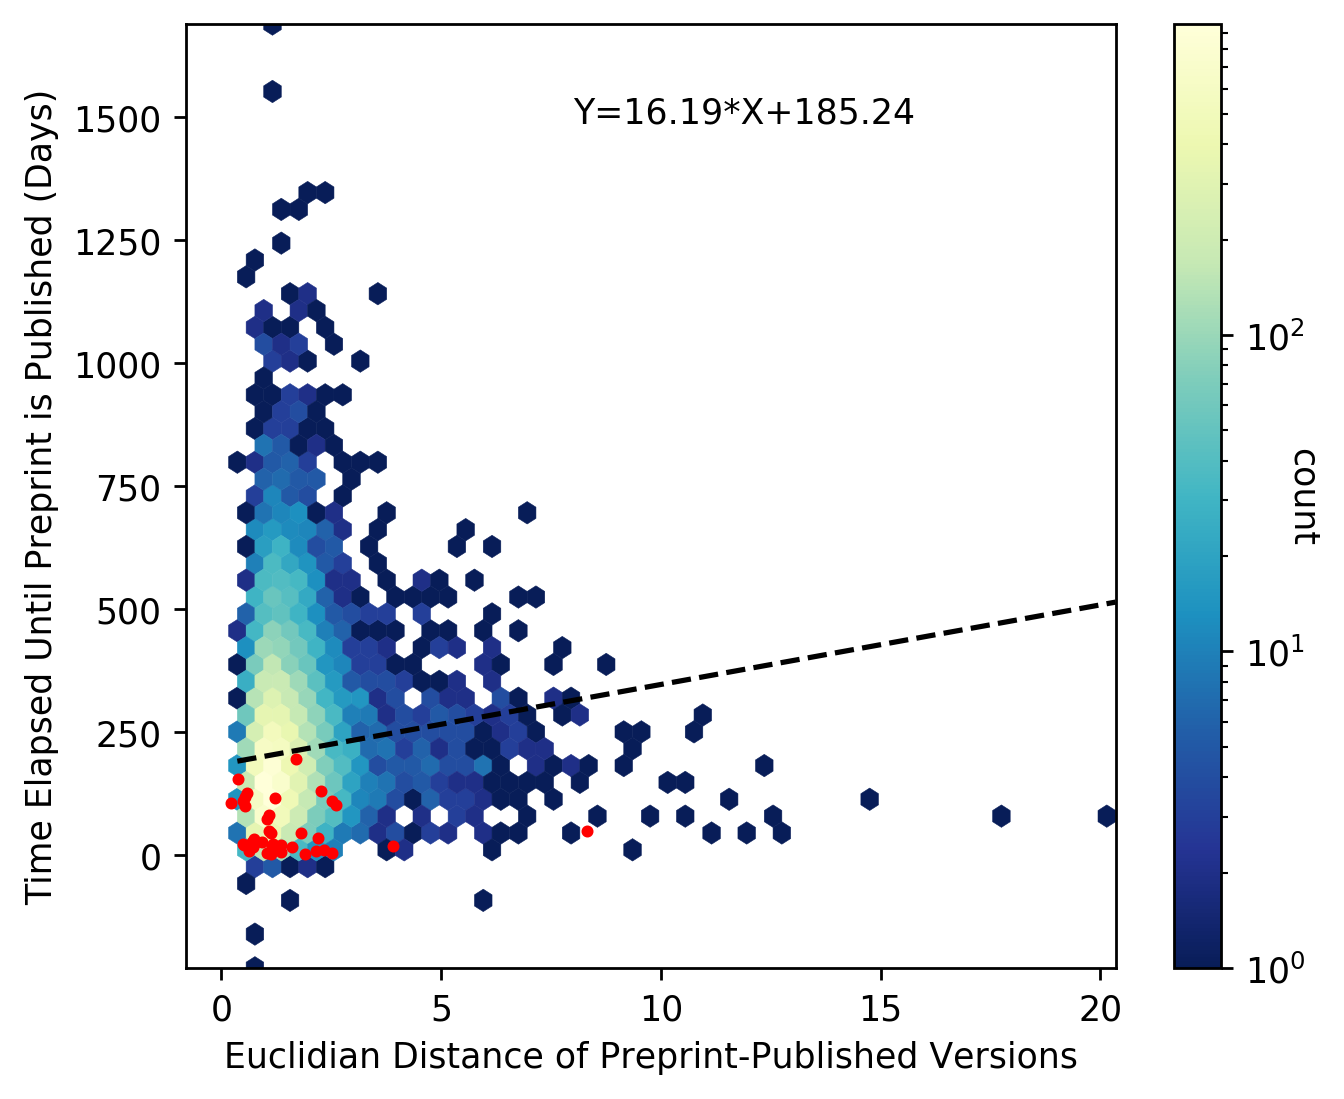

In [55]:
# graph here?
plt.figure(figsize=(6, 5))
ax = plt.hexbin(
    biorxiv_published_distances["doc_distances"],
    biorxiv_published_distances["days_to_published"],
    gridsize=50,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(),
    mincnt=1,
    linewidths=(0.15,)
    #     edgecolors=None
)
ax = plt.gca()
ax.plot(x_line, y_line, "--k")
ax.annotate(
    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
    (8, 1490),
)
_ = ax.set_xlabel("Euclidian Distance of Preprint-Published Versions")
_ = ax.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("count", rotation=270)
_ = ax.scatter(
    polka_published_preprint_df["doc_distances"],
    polka_published_preprint_df["days_to_published"],
    c="red",
    s=6,
)
plt.savefig("output/figures/article_distance_vs_publication_time_hex.svg", dpi=250)
plt.savefig("output/figures/article_distance_vs_publication_time_hex.png", dpi=250)